# Lab Three - Extending Logistic Regression

Tommy Greim

## Preperation and Overview
### Business Case
Rigorous study of abalones, a kind of mollusc, has revealed that there is a direct relationship between the number of ring in an abalone's shell and and its age. However, determining the number of rings is a labor and time intensive task, requiring researchers to cut through the shell, stain it, and count the rings under a microscope. Therefore, if it is  possible to determine the number of rings an abalone has based on other known characteristics about it, it could save researchers a great deal of time. This is, admittedly, an exceptionally narrow use case. Nevertheless, for those who'd use it, it'd be invaluable. Since it'd be used in research, the 'ring number classifier' would have to be exceptionally accurate, likely >95%, but possibly less. To determine a more precise number, one could observe abalone researchers and figure out how frequently they miscount the number of rings. So long as the classifier 'miscounts' less often than humans, then it'll prove useful.
### Pre-Processing the Data

In [2]:
import pandas as pd
import numpy as np
import missingno as mn

initData = pd.read_csv('/home/tommy/Downloads/abalone.data')
initData.groupby(['Rings']).size()
duplicates = initData.duplicated().loc[initData.duplicated() == True].count()
print("Number of duplicate values: ", duplicates)
print("Missing Values Present: ", initData.isnull().values.sum())
initData.info()

Number of duplicate values:  0
Missing Values Present:  0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole-Weight    4177 non-null   float64
 5   Shucked-Weight  4177 non-null   float64
 6   Viscera-Weight  4177 non-null   float64
 7   Shell-Weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [3]:
print(initData.groupby(['Rings']).size())
initData.head()

Rings
1       1
2       1
3      15
4      57
5     115
6     259
7     391
8     568
9     689
10    634
11    487
12    267
13    203
14    126
15    103
16     67
17     58
18     42
19     32
20     26
21     14
22      6
23      9
24      2
25      1
26      1
27      2
29      1
dtype: int64


,Sex,Length,Diameter,Height,Whole-Weight,Shucked-Weight,Viscera-Weight,Shell-Weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Before I use the data, I first one hot encode the sex class. Under normal circumstances, this would yield a single binary attribute; however, there are three unique values for sex in the dataset: male, female, and infant, so instead three attributes will be needed. I'm also discretizing the the number of rings into three ranges.

In [4]:
# One Hot Encoding Sex
temp = pd.get_dummies(initData['Sex'])
initData = pd.concat([initData, temp], axis=1).drop('Sex', axis=1)
initData.rename(columns={'F': 'Female', 'M': 'Male','I': 'Infant'}, inplace = True)
# del initData['Sex']

#Discretizing Ring Size
initData['Ring-Range'] = pd.cut(initData['Rings'],[0,8,10,30],
                                 labels=['1-8','9-10','11-30']) 
#initData['Ring-Range'] = initData['Ring-Range'].astype('uint8')
del initData['Rings']
initData.head()

,Length,Diameter,Height,Whole-Weight,Shucked-Weight,Viscera-Weight,Shell-Weight,Female,Infant,Male,Ring-Range
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0,0,1,11-30
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0,0,1,1-8
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,1,0,0,9-10
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0,0,1,9-10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0,1,0,1-8


I realize that 1-8, 9-10, and 11-30, are odd choices for ring ranges, but I wanted to ensure the number of entries per range was as similar as possible.

In [5]:
print(initData.groupby(['Ring-Range']).size())

Ring-Range
1-8      1407
9-10     1323
11-30    1447
dtype: int64


Next, I'll scale all the continuous variables, so that they rest between 0 and 1.

In [6]:
continuous_vars = ['Length', 'Diameter', 'Height', 'Whole-Weight', 'Shucked-Weight', 'Viscera-Weight', 'Shell-Weight']
for v in continuous_vars:
    # Taken from: https://www.geeksforgeeks.org/normalize-a-column-in-pandas/
    initData[v] = (initData[v]-initData[v].min())/(initData[v].max()-initData[v].min())

initData.head()

,Length,Diameter,Height,Whole-Weight,Shucked-Weight,Viscera-Weight,Shell-Weight,Female,Infant,Male,Ring-Range
0,0.513514,0.521008,0.084071,0.181335,0.150303,0.132324,0.147982,0,0,1,11-30
1,0.371622,0.352941,0.079646,0.079157,0.066241,0.063199,0.068261,0,0,1,1-8
2,0.614865,0.613445,0.119469,0.239065,0.171822,0.185648,0.207773,1,0,0,9-10
3,0.493243,0.521008,0.110619,0.182044,0.144250,0.149440,0.152965,0,0,1,9-10
4,0.344595,0.336134,0.070796,0.071897,0.059516,0.051350,0.053313,0,1,0,1-8


In [7]:
initData.describe()

,Length,Diameter,Height,Whole-Weight,Shucked-Weight,Viscera-Weight,Shell-Weight,Female,Infant,Male
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.606746,0.593078,0.123466,0.292808,0.241000,0.237121,0.236503,0.312904,0.321283,0.365813
std,0.162288,0.166790,0.037015,0.173681,0.149269,0.144324,0.138717,0.463731,0.467025,0.481715
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.506757,0.495798,0.101770,0.155658,0.124412,0.122449,0.128052,0.000000,0.000000,0.000000
50%,0.635135,0.621849,0.123894,0.282451,0.225286,0.224490,0.231689,0.000000,0.000000,0.000000
75%,0.729730,0.714286,0.146018,0.407650,0.336920,0.332456,0.326358,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
initData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Length          4177 non-null   float64 
 1   Diameter        4177 non-null   float64 
 2   Height          4177 non-null   float64 
 3   Whole-Weight    4177 non-null   float64 
 4   Shucked-Weight  4177 non-null   float64 
 5   Viscera-Weight  4177 non-null   float64 
 6   Shell-Weight    4177 non-null   float64 
 7   Female          4177 non-null   uint8   
 8   Infant          4177 non-null   uint8   
 9   Male            4177 non-null   uint8   
 10  Ring-Range      4177 non-null   category
dtypes: category(1), float64(7), uint8(3)
memory usage: 245.0 KB


### Splitting the Data

In [9]:
from sklearn import model_selection as ms

y = initData['Ring-Range'].values
X = initData.drop('Ring-Range', axis=1).to_numpy()


X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2)

# temp2 = y_train.to_numpy()
# count1 = (temp2 == '1-8').sum()
# count2 = (temp2 == '9-10').sum()
# count3 = (temp2 == '11-30').sum()
# print(count1, '|', count2, '|', count3)
# temp2 = y_test.to_numpy()
# count1 = (temp2 == '1-8').sum()
# count2 = (temp2 == '9-10').sum()
# count3 = (temp2 == '11-30').sum()
# print(count1, '|', count2, '|', count3)

### Why an 80/20 split works best for my dataset

There are two main reasons to reject an 80/20 split. The first would be if one class dominates the dataset, and the other would be if the dataset is small. In regard to the first, all three classes in my dataset are nearly equivilent in number, so it fails to meet this criteria. As for the second, what constitutes a small or large dataset isn't wholly agreed upon. That said, my dataset seems large enough to justify and 80/20 split.

## Modeling

The below code is imported from the class notebook. The LogisticRegression class has been modified to accept a user-provided regression method. BinaryLogisticRegression has a regularized gradient method, and all relevant classes have been modified to use this regularized gradient method.

In [10]:
import numpy as np
from scipy.special import expit
class BinaryLogisticRegressionBase:
    # private:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        return 'Base Binary Logistic Regression Object, Not Trainable'
    
    # convenience, private and static:
    @staticmethod
    def _sigmoid(theta):
        return 1/(1+np.exp(-theta)) 
    
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    # public:
    def predict_proba(self, X, add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    

class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001, reg=None):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.r = reg
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)

        # gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient
    
    def _reg_grad(self):
        if (self.r == 'L1'): 
            #return -1 * np.linalg.norm(self.w_[1:])
            return -1 * np.sign(self.w_[1:])
        
        elif (self.r == 'L2'): 
            #return -1 * np.square(self.w_[1:])
            return -1 * 2 * self.w_[1:]
        
        elif (self.r == 'L1L2'): 
             #return -1 * (np.square(self.w_[1:]) + np.linalg.norm(self.w_[1:]))
            return 1 * (np.sign(self.w_[1:]) + 2 * self.w_[1:])
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
            # add bacause maximizing 
        

from scipy.special import expit

class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # but overwrite the gradient calculation
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        if self._reg_grad() is not None:
            gradient[1:] += self._reg_grad() * self.C
        
        return gradient.reshape(self.w_.shape)

# from scipy.optimize import minimize_scalar
# import copy
# from numpy import ma # (masked array) this has most numpy functions that work with NaN data.
# class LineSearchLogisticRegression(BinaryLogisticRegression):
    
#     # define custom line search for problem
#     def __init__(self, line_iters=0.0, **kwds):        
#         self.line_iters = line_iters
#         # but keep other keywords
#         super().__init__(**kwds) # call parent initializer
    
#     @staticmethod
#     def objective_function(eta,X,y,w,grad,C):
#         wnew = w - grad*eta
#         g = expit(X @ wnew)
#         return -np.sum(ma.log(g[y==1]))-ma.sum(np.log(1-g[y==0])) + C*sum(wnew**2)
    
        
#     def fit(self, X, y):
#         Xb = self._add_bias(X) # add bias term
#         num_samples, num_features = Xb.shape
        
#         self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
#         # for as many as the max iterations
#         for _ in range(self.iters):
#             gradient = -self._get_gradient(Xb,y)
#             # minimization inopposite direction
            
#             # do line search in gradient direction, using scipy function
#             opts = {'maxiter':self.line_iters} # unclear exactly what this should be
#             res = minimize_scalar(self.objective_function, # objective function to optimize
#                                   bounds=(0,self.eta*10), #bounds to optimize
#                                   args=(Xb,y,self.w_,gradient,self.C), # additional argument for objective function
#                                   method='bounded', # bounded optimization for speed
#                                   options=opts) # set max iterations
            
#             eta = res.x # get optimal learning rate
#             self.w_ -= gradient*eta # set new function values
#             # subtract to minimize
                
            
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        if self._reg_grad() is not None:
            gradient[1:] += self._reg_grad() * self.C
        
        #gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient

from numpy.linalg import pinv
class HessianBinaryLogisticRegression(BinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        
        if self._reg_grad() is not None:
            gradient[1:] += self._reg_grad() * self.C
        # gradient[1:] += -2 * self.w_[1:] * self.C
        
        return pinv(hessian) @ gradient

# class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    
#     @staticmethod
#     def objective_function(w,X,y,C):
#         g = expit(X @ w)
#         # invert this because scipy minimizes, but we derived all formulas for maximzing
#         return -np.sum(ma.log(g[y==1]))-np.sum(ma.log(1-g[y==0])) + C*sum(w**2) 
#         #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

#     @staticmethod
#     def objective_gradient(w,X,y,C):
#         g = expit(X @ w)
#         ydiff = y-g # get y difference
#         gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
#         gradient = gradient.reshape(w.shape)
#         gradient[1:] += -2 * w[1:] * C
#         return -gradient
    
#     # just overwrite fit function
#     def fit(self, X, y):
#         Xb = self._add_bias(X) # add bias term
#         num_samples, num_features = Xb.shape
        
#         self.w_ = fmin_bfgs(self.objective_function, # what to optimize
#                             np.zeros((num_features,1)), # starting point
#                             fprime=self.objective_gradient, # gradient function
#                             args=(Xb,y,self.C), # extra args for gradient and objective function
#                             gtol=1e-03, # stopping criteria for gradient, |v_k|
#                             maxiter=self.iters, # stopping criteria iterations
#                             disp=False)
#         self.w_ = self.w_.reshape((num_features,1))

# Modified to include allow users to specify regression class, instead of only using VectorBinaryLogisticRegression.
class LogisticRegression:
    def __init__(self, eta, iterations=20, C=0.01, solvMethod = BinaryLogisticRegression, reg='None'):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.solvMethod = solvMethod
        self.r = reg
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        #print(self.unique_)
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = (y==yval) # create a binary problem
            # train the binary classifier for this class
            blr = self.solvMethod(eta=self.eta, iterations=self.iters, C=self.C, reg=self.r)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
    
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        # print(self.predict_proba(X))
        return self.unique_[np.argmax(self.predict_proba(X),axis=1)] # take argmax along row
    
    def _add_bias(self,X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term'
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient

In [11]:
#  either steepest ascent, stochastic gradient ascent, and {Newton's method/Quasi Newton methods}
solverAlias = {'steepest':VectorBinaryLogisticRegression,
               'stochastic':StochasticLogisticRegression,
               'newton':HessianBinaryLogisticRegression}

class CustomLogisiticRegressionWrapper:
    def __init__(self, eta, iterations=100, solver='steepest', reg='Neither', cost = 0.01):
        self.eta = eta
        self.iter = iterations
        self.C = cost
        self.reg = reg
        self.solv = LogisticRegression(eta=self.eta, iterations=self.iter, solvMethod=solverAlias[solver], C=self.C, reg=self.reg)
    
    def fit(self, X, y):
        return self.solv.fit(X,y)
    
    def predict(self, X):
        return self.solv.predict(X)


### Comparing Performance Across All Solvers, Regularizations, and C values

In [12]:
from sklearn.metrics import accuracy_score

solvers = ['steepest', 'stochastic', 'newton']
regs = ['L1', 'L2', 'L1L2']
Cs = np.arange(0,2.05,0.05)
theEta = 0.1
theIters = 10

results = []
for i in solvers:
    results.append(np.zeros((len(Cs),len(regs))))

for i in range(len(solvers)):
    print("Solver: ", solvers[i])
    for j in range(len(regs)):
        for k in range(len(Cs)):
            lr = CustomLogisiticRegressionWrapper(eta=theEta,iterations=theIters,solver=solvers[i], cost=Cs[k], reg=regs[j])
            lr.fit(X_train,y_train)
            yhat = lr.predict(X_test)
            results[i][k,j] = accuracy_score(y_test,yhat)

Solver:  steepest
Solver:  stochastic
Solver:  newton


(0.25, 0.65)

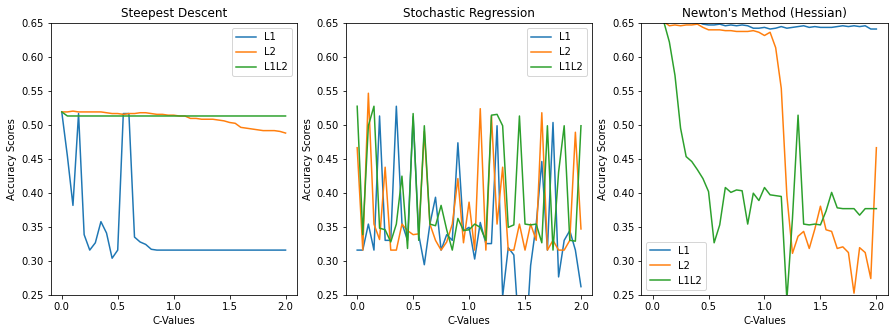

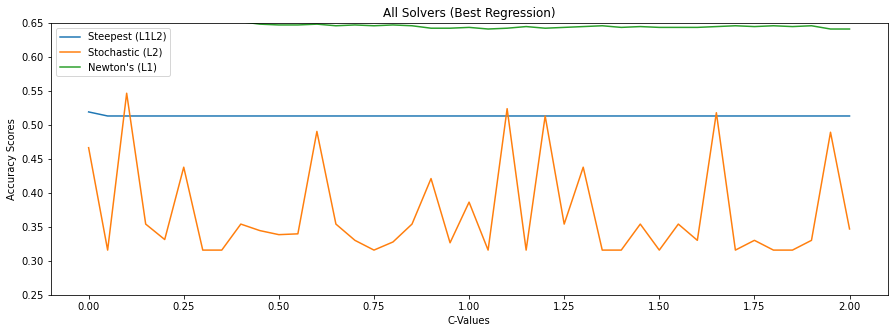

In [13]:
import matplotlib.pyplot as plt



plt.subplots(figsize=(15, 5))
plt.subplot(1,3,1)
steepL1 = plt.plot( Cs, results[0][:,0], label="L1")
steepL2 = plt.plot(Cs, results[0][:,1], label ='L2')
steepL1L2 = plt.plot(Cs, results[0][:,2], label='L1L2')
plt.legend()
plt.title("Steepest Descent")
plt.xlabel("C-Values")
plt.ylabel("Accuracy Scores")
plt.ylim(0.25, 0.65)
plt.subplot(1,3,2)
stochL1 = plt.plot( Cs, results[1][:,0], label="L1")
stochL2 = plt.plot(Cs, results[1][:,1], label ='L2')
stochL1L2 = plt.plot(Cs, results[1][:,2], label='L1L2')
plt.legend()
plt.title("Stochastic Regression")
plt.xlabel("C-Values")
plt.ylabel("Accuracy Scores")
plt.ylim(0.25, 0.65)
plt.subplot(1,3,3)
newtonL1 = plt.plot( Cs, results[2][:,0], label="L1")
newtonL2 = plt.plot(Cs, results[2][:,1], label ='L2')
newtonL1L2 = plt.plot(Cs, results[2][:,2], label='L1L2')
plt.legend()
plt.title("Newton's Method (Hessian)")
plt.xlabel("C-Values")
plt.ylabel("Accuracy Scores")
plt.ylim(0.25, 0.65)

plt.figure(figsize=(15,5))
steepBest1 = plt.plot( Cs, results[0][:,2], label="Steepest (L1L2)")
stochBest = plt.plot(Cs, results[1][:,1], label ='Stochastic (L2)')
newtonBest = plt.plot(Cs, results[2][:,0], label='Newton\'s (L1)')
plt.legend()
plt.title("All Solvers (Best Regression)")
plt.xlabel("C-Values")
plt.ylabel("Accuracy Scores")
plt.ylim(0.25, 0.65)

From here, it's clear the Newton's Method (Hessian) with L1 regularization is the best option for my dataset

In [14]:
a = results[2][:,0]
ind = np.argpartition(a, -1)[-1:]
#ind
bestC = float(Cs[ind])
print("Best C-Value Tested for Newton's Method w/ L1: ", bestC)

Best C-Value Tested for Newton's Method w/ L1:  0.0


Now, I'll run the classifier with these optimal characteristics.

In [15]:
np.seterr(divide = 'ignore') 
lr = CustomLogisiticRegressionWrapper(eta=0.01,iterations=5,solver='newton', cost=bestC, reg='L1')
lr.fit(X_train,y_train)

yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.6602870813397129


With this in mind, let's check the classifer for data snooping.

In [16]:
iters = np.arange(1,10,1)
iters = np.concatenate((iters,np.arange(10, 100, 5)))
iters = np.concatenate((iters,np.arange(100, 301, 20)))
# iters contain 1,2,...,10, and 10,15,20,...,50
trainScores = []
testScores = []
for i in iters:
    lrIter = CustomLogisiticRegressionWrapper(eta=0.01,iterations=i,solver='newton', cost=bestC, reg='L1')
    lrIter.fit(X_train,y_train)
    trainHat = lrIter.predict(X_train)
    trainScores.append(accuracy_score(y_train,trainHat))
    testHat = lrIter.predict(X_test)
    testScores.append(accuracy_score(y_test,testHat))


array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  15,  20,  25,
        30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,  85,  90,
        95, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300])

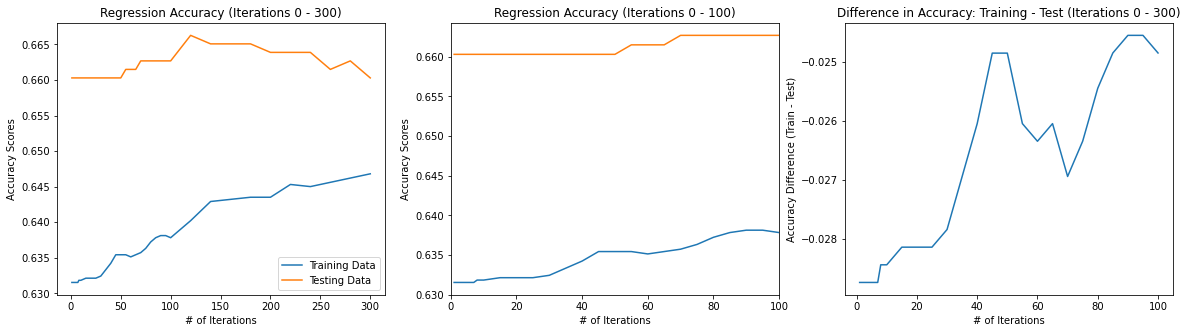

In [17]:
trainScores = np.array(trainScores)
testScores = np.array(testScores)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(iters, trainScores, label="Training Data")
plt.plot(iters, testScores, label ="Testing Data")
plt.xlabel("# of Iterations")
plt.ylabel("Accuracy Scores")
plt.title("Regression Accuracy (Iterations 0 - 300)")
plt.legend()
plt.subplot(1,3,2)
plt.xlim(0,100)
plt.plot(iters[:28], trainScores[:28], label="Training Data")
plt.plot(iters[:28], testScores[:28], label ="Testing Data")
plt.xlabel("# of Iterations")
plt.ylabel("Accuracy Scores")
plt.title("Regression Accuracy (Iterations 0 - 100)")
plt.subplot(1,3,3)
# plt.xlim(0,100)
plt.plot(iters[:28], trainScores[:28] - testScores[:28])
plt.xlabel("# of Iterations")
plt.ylabel("Accuracy Difference (Train - Test)")
plt.title("Difference in Accuracy: Training - Test (Iterations 0 - 300)")
# plt.semilogy()
iters

The left plot was supposed to demonstrate whether or not there was data snooping. I was going to check if the accuracy diverged after a certain number of iterations, and, if it did, I would say there was data snooping, and if it didn't diverge, I'd say it didn't. However, cards on the table, I don't really know what to say about the left graph. I'm not sure why accuracy decreases across the board after about 100 iterations. If I had to guess, it might be some math error in the Hessian Regression class, or maybe not. I didn't see any warnings, but that doesn't entirely rule it out. Assuming that the >100 iteration data is erroneous, as I do in the righthand graphs, it's clear that the accuracy gap is increasing with the number of iterations. However, the accuracy of the training prediction is not increasing at the expense of the testing prediction, which is to say that, generally, the testing and training accuracies are both improving with increasing iterations. Based on that, I don't think there's any data snooping present.

### Comparing my optimal Newton-L1 Classifer scikit-learn)

In [18]:
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from time import perf_counter

# Since scikit with default settings uses max_iter=300, I think it's only fair that my regression method
# uses its best value under 300, which is calculated here.
ind2 = int(np.argpartition(testScores, -1)[-1:])
bestIter = iters[ind2]
lrMine = CustomLogisiticRegressionWrapper(eta=0.01,iterations=bestIter,solver='newton', cost=bestC, reg='L1')
lrSk = SKLogisticRegression(max_iter=300) # all params default, save max_iter
lrSk.fit(X_train, y_train)

mineAvg = []
skAvg = []
for i in range(100):
    #Mine
    startMine = perf_counter()
    lrMine.fit(X_train, y_train)
    endMine = perf_counter()
    mineAvg.append(endMine - startMine)
    #SciKit
    startSk = perf_counter()
    lrSk.fit(X_train, y_train)
    endSk = perf_counter()
    skAvg.append(endSk - startSk)

My accuracy:  0.666267942583732
scikit-learn's accuracy:  0.6555023923444976


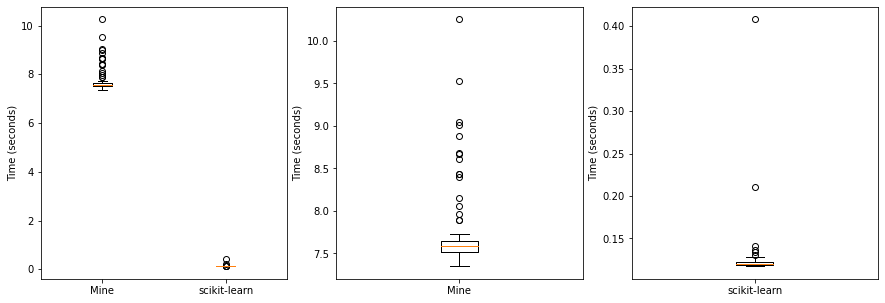

In [19]:
# The variable names mineAvg and skAvg are total misnomers, but the block of code above took a long
# time to run and I don't want to rerun it just to change the variable names
mineAvg = np.array(mineAvg)
skAvg = np.array(skAvg)
bothData = np.dstack((mineAvg,skAvg))
bothData = np.squeeze(bothData)
labels = ['Mine','scikit-learn']
bothData.shape
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.boxplot(bothData, labels=labels)
plt.ylabel("Time (seconds)")
plt.subplot(1,3,2)
plt.boxplot(mineAvg, labels=['Mine'])
plt.ylabel("Time (seconds)")
plt.subplot(1,3,3)
plt.boxplot(skAvg, labels=['scikit-learn'])
plt.ylabel("Time (seconds)")
#plt.boxplot(skAvg)

#And also, the accuracy
mineHat = lrMine.predict(X_test)
print("My accuracy: ", accuracy_score(y_test,mineHat))
skHat = lrSk.predict(X_test)
print("scikit-learn's accuracy: ", accuracy_score(y_test,skHat))

Based on the boxplots above, it's immediately obvious that SKLogisticRegression is leagues faster than my regression, and more consistent to boot. That said, my regression did produce a 1% more accurate model. However, I would be reluctant to claim that my model is unilaterally more accurate that scikit-learn's. After tweaking with the settings, scikit-learn might yield better results, but, in comparison to the SKLogisticRegression in it's default state, mine is more accurate.

## Deployment

I'd recommend using my regression in a deployed model, by virtue of its superior accuracy score. While modeling speed is important on the developer's end, once the model is already created and deployed, accuracy is far more important. That said, my recommendation is contingent on two assumptions: first, that my model is not only more accurate for my dataset, but other datasets as well, even those of wildly differing size, and second, that the SKLogisiticRegression cannot be tweaked to yield superior accuracy. Both of these are hefty assumptions, and I'm skeptical that they're true, the later assumption especially. That all said, so far as it pertains to my particular business case, I wouldn't recommend deploying either, as 63% accuracy is not good enough to satisfy it.

## Exceptional Work

In [34]:
class OVOLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.01, solvMethod = BinaryLogisticRegression, reg='None'):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.solvMethod = solvMethod
        self.r = reg
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        np.sort(self.unique_)
        for y1 in self.unique_:
            for y2 in self.unique_:
                if y2 <= y1:
                    continue
                ind1 = np.where(y == y1)
                ind2 = np.where(y == y2)
                ind = np.concatenate((ind1[0],ind2[0]))
                np.sort(ind)
                y_ovo = (y[ind] == y1)
                blr = self.solvMethod(eta=self.eta, iterations=self.iters, C=self.C, reg=self.r)
                blr.fit(X[ind], y_ovo)
                self.classifiers_.append((blr, (y1,y2)))
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x[0].w_ for x in self.classifiers_]).T
    
    def predict_proba(self,X):
        probs = []
        for x in self.classifiers_:
            probs.append(x[0].predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        probs = self.predict_proba(X)
#         unique_scores = np.zeros(len(self.unique_))
#         unique_and_scores = np.hstack((self.unique_, unique_scores))
        unique_scores = {}
        for x in self.unique_:
            unique_scores[x] = 0
        for i in range(len(self.classifiers_)):
            print(probs[i])
            if probs[i] > 0.5:
                unique_scores[self.classifiers_[i][1][0]] = unique_scores[self.classifiers_[i][1][0]] + 1
            else:
                unique_scores[self.classifiers_[i][1][1]] = unique_scores[self.classifiers_[i][1][1]] + 1
        return max(unique_scores, key=unique_scores.get)
        #return self.unique_[np.argmax(self.predict_proba(X),axis=1)] # take argmax along row
    
    def _add_bias(self,X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term'
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient

In [35]:
class OVOLogisiticRegressionWrapper:
    def __init__(self, eta, iterations=100, solver='steepest', reg='Neither', cost = 0.01):
        self.eta = eta
        self.iter = iterations
        self.C = cost
        self.reg = reg
        self.solv = OVOLogisticRegression(eta=self.eta, iterations=self.iter, solvMethod=solverAlias[solver], C=self.C, reg=self.reg)
    
    def fit(self, X, y):
        return self.solv.fit(X,y)
    
    def predict(self, X):
        return self.solv.predict(X)

In [36]:
lrOVO = OVOLogisiticRegressionWrapper(eta=0.1,iterations=10,solver='newton', cost=0.01, reg='L1')

In [37]:
lrOVO.fit(X_train, y_train)

In [38]:
hatOVO = lrOVO.predict(X_test)
print(accuracy_score(y_test, hatOVO))

[0.55124453 0.54564568 0.45562658]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()